**A better understanding of PyMC objects using linear regression**

I previously [wrote](https://benslack19.github.io/prior-likelihood-posterior-predictive/) about my discovery of [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/). The book's title could not be more spot-on--it's helped me look at statistics in a different way. This approach will set me up (hopefully) for learning new methods that will prove useful in my work.

I'm doing the problems with the Python package [PyMC3](https://docs.pymc.io/). Fortunately, a repo for the book's code using this package has already been created [here](https://github.com/pymc-devs/resources/tree/master/Rethinking_2). This repo gave me a starting point to write my own code and compare to the book's, which is written in R. I've also never used the PyMC3 package before so I took this as an opportunity to dive deep into some of the package's objects. The [PyMC3](https://docs.pymc.io/notebooks/api_quickstart.html) documentation of course was also helpful.

In this post, I will address a linear regression problem using PyMC3. Along the way, I'll inspect some of the objects and integrate some of the book's lessons. This exercise of object inspection not only helped me understand PyMC3, but it also strengthen the theoretical concepts underlying this approach.

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


<IPython.core.display.Javascript object>

In [3]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


<IPython.core.display.Javascript object>

Of course, it's good to be cognizant of package versions so I am making tht clear here.

In [15]:
%watermark -n -u -v -iv -w

Last updated: Sat Mar 06 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
seaborn   : 0.11.1
scipy     : 1.6.0
matplotlib: 3.3.4
json      : 2.0.9
pymc3     : 3.11.0
arviz     : 0.11.1
numpy     : 1.20.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>

**Question**

Ths question come's from the [winter 2020, week 2 homework](https://github.com/rmcelreath/stat_rethinking_2020/blob/main/homework/week02/week02.pdf).

**The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.**

| Individual | weight | expected height | 89% interval |
| ------ | ------ | -------- | ---------- |
| 1|  45  |  |
| 2 | 40 |  |  |
| 3 | 65 | |  |
|4  | 31  |  |  |

Let's quickly take a look at the data to get a handle on what we're working with.

In [5]:
d = pd.read_csv("../data/a_input/Howell1.csv", sep=";", header=0)
d2 = d[d.age >= 18]  # filter to get only adults

d2.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='weight', ylabel='height'>

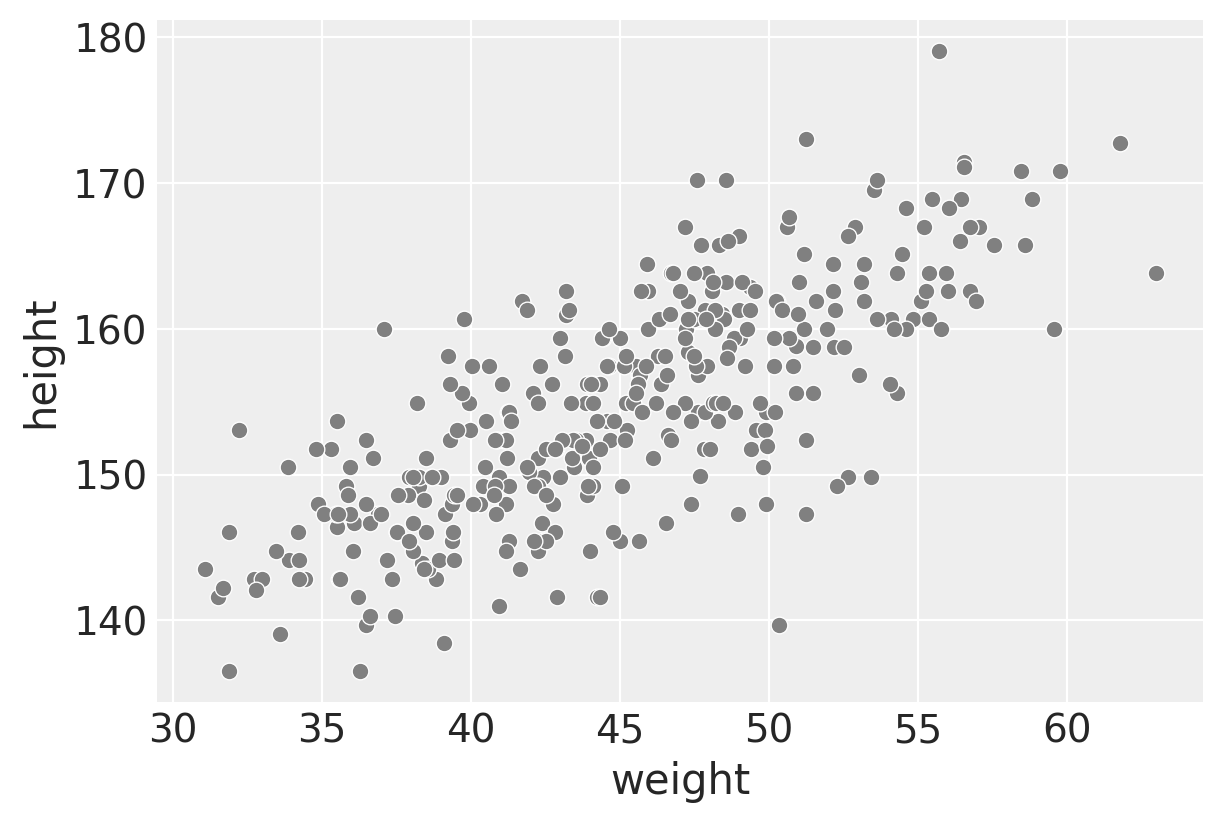

<IPython.core.display.Javascript object>

In [63]:
f, ax1 = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=d2, x="weight", y="height", color="gray")

We'd expect a linear relationship between `weight` and `height` in the adult population and that's what we see here.

# Setting up the variables, producing `model `and `trace` objects

First, I'll need to generate the posterior distribution from the entire dataset. I'll define the variables:

$\text{height}_i$ ~ Normal($\mu_i, \sigma$)
<br>
$\mu_i = \alpha + \beta(x_i  - \bar{x})$
<br>
$\alpha$ ~ $\text{Normal}(178, 20)$
<br>
$\beta$ ~ $\text{Log-Normal}(0, 1)$
<br>
$\sigma$ ~ $\text{Uniform}(0, 50)$

Important things to note about these variables.
- Whether the subscript *i* is there for a given variable matters. It will represent every row in the set of parameters returned by the function. We'll come back to this later.
- The tilde versus the equals sign matters. The former represents a stochastic relationship while the latter is deterministic.
- I used a prior for beta that will have a sensical relationship, such as being all positive. One way to accomplish this is to use lognormal.



In [10]:
# Get the average weight as part of the model definition
xbar = d2.weight.mean()

<IPython.core.display.Javascript object>

In [156]:
with pm.Model() as heights_model:

    # Priors are variables a, b, sigma
    # using pm.Normal is a way to represent the stochastic relationship the left has to right side of equation
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)

    # This is a linear model (not really a prior or likelihood?)
    # Data included here (d2.weight, which is observed)
    # Mu is deterministic, but a and b are stochastic
    mu = a + b * (d2.weight - xbar)

    # Likelihood is height variable, which is also observed (data included here, d2.height))
    # Height is dependent on deterministic and stochastic variables
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)

    # The next lines is doing the fitting and sampling all at once.
    # When I ran this without the return_inferencedata parameter set, I got a
    # warning and suggestion to set this explicitly. I wanted to see the difference.
    # Per the documentation: "With PyMC3 version >=3.9 the return_inferencedata=True
    # kwarg makes the sample function return an arviz.InferenceData object instead
    # of a MultiTrace. InferenceData has many advantages, compared to a MultiTrace.
    trace_m1 = pm.sample(1000, tune=1000, return_inferencedata=True)  #
    trace_m2 = pm.sample(1000, tune=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
INFO:pymc3:NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
INFO:pymc3:NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


<IPython.core.display.Javascript object>

# Inspecting the `pymc3` objects

Before going through the rest of the exercise, it is helpful to dive deep and understand the objects in this call.

## Inspecting the `model` object

In [39]:
heights_model

<IPython.core.display.Javascript object>

Now let's take a look at the object's properties and methods, using the Python `dir` function. It returned a long list so let's limit using `filter` and a lambda function to those without the double underscore. (If you really want to understand what the attribues with underscores are, you can look [here](https://stackoverflow.com/questions/1301346/what-is-the-meaning-of-single-and-double-underscore-before-an-object-name).)

In [40]:
# But this is a way to limit the attributes to inspect
heights_model_methods2check = list(filter(lambda x: "__" not in x, dir(heights_model)))
heights_model_methods2check

['RV_dims',
 'Var',
 '_cache',
 '_config_context',
 '_context_class',
 '_parent',
 '_repr_latex_',
 '_str_repr',
 '_theano_config',
 'a',
 'add_coords',
 'add_random_variable',
 'b',
 'basic_RVs',
 'bijection',
 'check_bounds',
 'check_test_point',
 'cont_vars',
 'contexts',
 'coords',
 'd2logp',
 'd2logp_nojac',
 'datalogpt',
 'deterministics',
 'dict_to_array',
 'disc_vars',
 'dlogp',
 'dlogp_array',
 'dlogp_nojac',
 'fastd2logp',
 'fastd2logp_nojac',
 'fastdlogp',
 'fastdlogp_nojac',
 'fastfn',
 'fastlogp',
 'fastlogp_nojac',
 'flatten',
 'fn',
 'free_RVs',
 'height',
 'isroot',
 'logp',
 'logp_array',
 'logp_dlogp_function',
 'logp_elemwise',
 'logp_nojac',
 'logp_nojact',
 'logpt',
 'makefn',
 'missing_values',
 'model',
 'name',
 'name_for',
 'name_of',
 'named_vars',
 'ndim',
 'observed_RVs',
 'parent',
 'potentials',
 'prefix',
 'profile',
 'root',
 'shape_from_dims',
 'sigma',
 'test_point',
 'unobserved_RVs',
 'varlogpt',
 'vars']

<IPython.core.display.Javascript object>

It is still a pretty long list but we can poke around at a few of the attributes.

In [41]:
heights_model.basic_RVs

[a ~ Normal,
 b_log__ ~ TransformedDistribution,
 sigma_interval__ ~ TransformedDistribution,
 height ~ Normal]

<IPython.core.display.Javascript object>

In [43]:
heights_model.height

height ~ Normal

<IPython.core.display.Javascript object>

Most of the information related to our input. Let's look at the `trace` objects, which were a result of the `pm.sample` command.

## Inspecting the `trace` variables

The `trace` object contains the samples collected, in the order they were collected per the [getting started](https://docs.pymc.io/notebooks/getting_started.html) tutorial. This is an important object so I wanted to dive deeper into it.

Note that I used the variable name "trace" simply because the repo version produced a `MultiTrace` object, which is what happens when the `return_inferencedata` flag is not set. As you'll see, in the first example, it is probably not the best name, but I'll leave the names alone for now.

### `trace_m1` is a `arviz.InferenceData`

Let's start off by simply looking at the object.

In [24]:
type(trace_m1)

arviz.data.inference_data.InferenceData

<IPython.core.display.Javascript object>

In [19]:
trace_m1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

<IPython.core.display.Javascript object>

This was good to see, but I could go down a whole 'nother rabbit hole with just this object's attributes and functions. I'll leave it to [this Arviz page](https://arviz-devs.github.io/arviz/getting_started/XarrayforArviZ.html) to explain this object in more detail. I'll focus on the `trace_m2` object but here is a way to connect it with the posterior data from `trace_m1`.

In [38]:
trace_m1.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    a        (chain, draw) float64 154.0 154.0 155.1 154.1 ... 154.9 154.3 154.9
    b        (chain, draw) float64 0.8538 0.8616 0.9578 ... 0.866 0.9321 0.8399
    sigma    (chain, draw) float64 4.989 5.129 5.068 4.961 ... 5.09 5.019 5.242
Attributes:
    created_at:                 2021-03-06T16:21:39.455184
    arviz_version:              0.11.1
    inference_library:          pymc3
    inference_library_version:  3.11.0
    sampling_time:              11.264967918395996
    tuning_steps:               1000

<IPython.core.display.Javascript object>

### `trace_m2` is a `MultiTrace` object

The `MultiTrace` object that is outputted as a result of setting `return_inferencedata=False` in the `pm.sample()` call. (It's the same object that is outputted in the PyMC3 repo of the book's code which is why I decided to work with it here.) This is an important object so I wanted to dive deeper into it.

In [49]:
type(trace_m2)

pymc3.backends.base.MultiTrace

<IPython.core.display.Javascript object>

The trace object contains the samples collected, in the order they were collected per the PyMC3's. [getting started tutorial](https://docs.pymc.io/notebooks/getting_started.html).  It is much clearer to see this concretely when we use the `trace_to_dataframe` function.

In [55]:
trace_m2_df = pm.trace_to_dataframe(trace_m2)
trace_m2_df

,a,b,sigma
0,154.589194,0.889071,4.885394
1,154.589194,0.889071,4.885394
2,154.818923,0.838186,5.271951
3,154.920790,0.987778,5.107954
4,154.920790,0.987778,5.107954
...,...,...,...
3995,154.393120,0.915738,5.082579
3996,155.231970,0.894059,5.201840
3997,154.932506,0.905143,5.038751
3998,154.841507,0.881522,5.391670


<IPython.core.display.Javascript object>

Why are there 4000 rows? It can be explained by looking at some of the earlier code and the output.

This was in the initial model fitting:
<br>
`trace_m = pm.sample(1000, tune=1000)`
<br>
`Multiprocess sampling (4 chains in 4 jobs)`

I don't know how to take into account this multiprocess sampling, so I'll treat the 4000 rows as simply being different samples drawn from the posterior distribution. More explanation is shown [here](https://stackoverflow.com/questions/61969968/understanding-the-parameters-of-pymc3-package).

As you can see, each row is a different instantiation of alpha, beta, and sigma values. Each row is a different "*i*th" set of values that is in these equations.

$\text{height}_i$ ~ Normal($\mu_i, \sigma$)
<br>
$\mu_i = \alpha + \beta(x_i  - \bar{x})$

We'll come back to this. We can also check out the object attributes.

In [103]:
trace_m2_methods2check = list(filter(lambda x: "__" not in x, dir(trace_m2)))
trace_m2_methods2check

['_attrs',
 '_report',
 '_slice',
 '_straces',
 'add_values',
 'chains',
 'get_sampler_stats',
 'get_values',
 'nchains',
 'point',
 'points',
 'remove_values',
 'report',
 'stat_names',
 'varnames']

<IPython.core.display.Javascript object>

The last few attributes looked important.

In [105]:
# Trace object's variable names
trace_m2.varnames

['a', 'b_log__', 'sigma_interval__', 'b', 'sigma']

<IPython.core.display.Javascript object>

In [107]:
# Inspect samples, which are parameters
print("a samples: ", trace_m2["a"][0:5])
print("b samples: ", trace_m2["b"][0:5])
print("sigma samples: ", trace_m2["sigma"][0:5])
# print("mu samples: ", trace_m["mu"][0:5])
# print("height samples: ", trace_m["height"][0:5])

print("mu and height are deterministic or dependent on deterministic variables")

a samples:  [154.58919424 154.58919424 154.81892314 154.92078981 154.92078981]
b samples:  [0.88907119 0.88907119 0.83818599 0.9877783  0.9877783 ]
sigma samples:  [4.88539414 4.88539414 5.27195133 5.10795395 5.10795395]
mu and height are deterministic or dependent on deterministic variables


<IPython.core.display.Javascript object>

In [108]:
# Another way to inspect
trace_m2.get_values("a")[0:5]

array([154.58919424, 154.58919424, 154.81892314, 154.92078981,
       154.92078981])

<IPython.core.display.Javascript object>

A chain is a single run of MCMC. I don't understand this yet, but it is explained [here](https://stackoverflow.com/questions/49825216/what-is-a-chain-in-pymc3).

In [109]:
trace_m2.chains

[0, 1, 2, 3]

<IPython.core.display.Javascript object>

In [111]:
# Not sure how to use this yet
trace_m2.get_sampler_stats

<bound method MultiTrace.get_sampler_stats of <MultiTrace: 4 chains, 1000 iterations, 5 variables>>

<IPython.core.display.Javascript object>

In [112]:
# Not sure how to use this yet
# trace_m2.report["a"]
trace_m2.report

<IPython.core.display.Javascript object>

In [113]:
# not sure how to use this yet
trace_m2.stat_names

{'depth',
 'diverging',
 'energy',
 'energy_error',
 'max_energy_error',
 'mean_tree_accept',
 'model_logp',
 'perf_counter_diff',
 'perf_counter_start',
 'process_time_diff',
 'step_size',
 'step_size_bar',
 'tree_size',
 'tune'}

<IPython.core.display.Javascript object>

## Code explanation

With regards to the sampling in the code above. This is taken from the PyMC example notebook.

> We could use a quadratic approximation like McElreath does in his book and we did in code 2.6. But Using PyMC3 is really simple to just sample from the model using a "sampler method". Most common sampler methods are members of the Markov Chain Monte Carlo Method (MCMC) family (for details read Section 2.4.3 and Chapter 8 of Statistical Rethinking).

> PyMC3 comes with various samplers. Some samplers are more suited than others for certain type of variable (and/or problems). For now we are going to let PyMC3 choose the sampler for us. PyMC3 also tries to provide a reasonable starting point for the simulation. By default PyMC3 uses the same adaptive procedure as in STAN `'jitter+adapt_diag'`, which starts with a identity mass matrix and then adapts a diagonal based on the variance of the tuning samples.

> You can read more details of PyMC3 [here](https://docs.pymc.io/notebooks/getting_started.html).

This is taken from the link which helps explain the code.

> **Gradient-based sampling methods**

> PyMC3 has the standard sampling algorithms like adaptive Metropolis-Hastings and adaptive slice sampling, but PyMC3’s most capable step method is the No-U-Turn Sampler. NUTS is especially useful on models that have many continuous parameters, a situation where other MCMC algorithms work very slowly. It takes advantage of information about where regions of higher probability are, based on the gradient of the log posterior-density. This helps it achieve dramatically faster convergence on large problems than traditional sampling methods achieve. PyMC3 relies on Theano to analytically compute model gradients via automatic differentiation of the posterior density. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo. For random variables that are undifferentiable (namely, discrete variables) NUTS cannot be used, but it may still be used on the differentiable variables in a model that contains undifferentiable variables.

> NUTS requires a scaling matrix parameter, which is analogous to the variance parameter for the jump proposal distribution in Metropolis-Hastings, although NUTS uses it somewhat differently. The matrix gives the rough shape of the distribution so that NUTS does not make jumps that are too large in some directions and too small in other directions. It is important to set this scaling parameter to a reasonable value to facilitate efficient sampling. This is especially true for models that have many unobserved stochastic random variables or models with highly non-normal posterior distributions. Poor scaling parameters will slow down NUTS significantly, sometimes almost stopping it completely. A reasonable starting point for sampling can also be important for efficient sampling, but not as often.

> PyMC3 automatically initializes NUTS to reasonable values based on the variance of the samples obtained during a tuning phase. A little bit of noise is added to ensure different, parallel, chains start from different points. Also, PyMC3 will automatically assign an appropriate sampler if we don’t supply it via the step keyword argument...

# Interpreting the posterior distribution

Interpretation can be helped by generating tables and making plots of simulated data. The latter will be more helpful to know:
1. Whether the model fit procedure worked correctly
2. Gaining a sense for whether the absolute magnitude, and not just the relative magnitude, of a relationship between outcome and predictor.
3. The uncertainty surrounding an average relationship
4. The uncertainty surrounding the implied predictions of the model, as there are distinct from mere parameter uncertainty

For each variable, we are going from a pretty wide distribution in the priors to a really narrow distribution in the posterior. It's all the more striking when you compare the probability density values between the left (prior) and right (posterior) y-axes.

## Tables of marginal distributions

The tables here look like summary statistics but the term "marginal" here refers to “averaging over the other parameters.” We can get some helpful summaries for $\alpha, \beta$, and $\sigma$ to help with model inspection.

Point estimates are not the most useful ultimately, but here is how to return the *maximum a posteri* estimates for the model.

In [140]:
pm.find_MAP(model=heights_model)

{'a': array(154.60136748),
 'b_log__': array(-0.10172172),
 'sigma_interval__': array(-2.18135226),
 'b': array(0.90328088),
 'sigma': array(5.07188029)}

<IPython.core.display.Javascript object>

The next set of code gives both the MAP as well as providing a sense of the variance of the data, which is more useful.

In [146]:
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
az.summary(trace_m2, round_to=3, kind="stats")

/Users/blacar/opt/anaconda3/envs/stats_rethinking_min/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,154.600,0.268,154.209,155.059
b,0.903,0.042,0.834,0.968
sigma,5.105,0.199,4.786,5.409


<IPython.core.display.Javascript object>

 (Note that inputting the object `trace_m1` will return the data without a warning.)

The following is a way to get the covariances among the parameters (variance-covariance matrix).

In [148]:
trace_m2_df.cov().round(3)

,a,b,sigma
a,0.072,-0.000,-0.001
b,-0.000,0.002,-0.000
sigma,-0.001,-0.000,0.039


<IPython.core.display.Javascript object>

The other way of looking at it this variance-covariance matrix is to break it down into two elements:
1. A vector of variances for the parameters.
2. A correlation matrix that tells how changes in any parameter lead to correlated changes in the others.

In [149]:
# The vector of variances for the parameters
# Note how the function call is reflected in the numbers above
print("Variances of parameters: ", np.diag(trace_m2_df.cov()))

Variances of parameters:  [0.07186415 0.00177983 0.0394553 ]


<IPython.core.display.Javascript object>

These are a vector of variances so taking the square root for each will give the same standard deviations in the `az.summary` call above.

In [151]:
# Get the standard deviations back
print("Standard deviations of parameters: ", np.sqrt(np.diag(trace_m2_df.cov())))

Standard deviations of parameters:  [0.26807489 0.04218804 0.19863359]


<IPython.core.display.Javascript object>

The correlation matrix can show how changing one parameter affects another.

In [153]:
trace_m2_df.corr()

,a,b,sigma
a,1.000000,-0.003559,-0.016757
b,-0.003559,1.000000,-0.010885
sigma,-0.016757,-0.010885,1.000000


<IPython.core.display.Javascript object>

Like in the book: "Very little covariation among the parameters in this case. Using pairs(m4.3) shows both the marginal posteriors and the covariance. In the practice problems at the end of the chapter, you’ll see that the lack of covariance among the parameters results from CENTERING."

## Visualizing the prior and posterior distributions

Plotting can be very helpful for model diagnostics. I started off plotting some things with `seaborn` and `scipy.stats` functions, but then used some `arviz` functions that are built for these kinds of data.

Let's visualize at the prior and posterior distributions of our parameters. I'm using the `scipy.stats` normal, lognormal, and uniform distributions for alpha, beta, and sigma prior distributions. (They each have a vector length of 4000 to match the posterior's length, but this is arbitrary. I'm using the `trace_m2` object's returned parameters for the posterior.

<ipython-input-154-9fe321eccdfc>:40: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


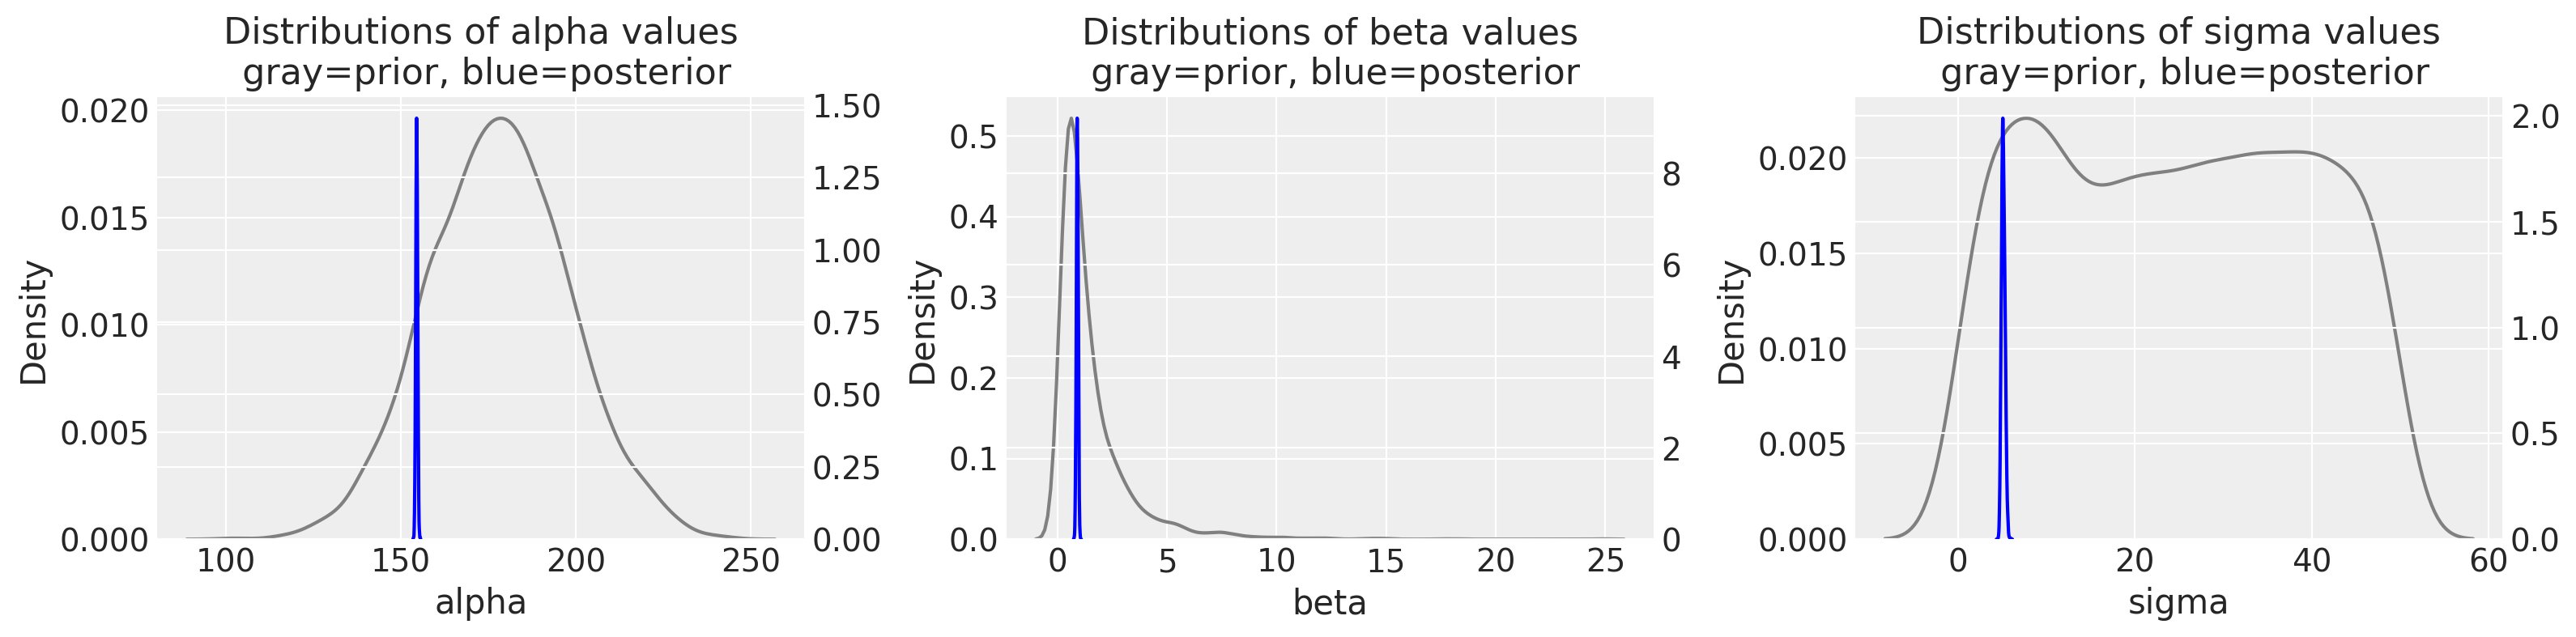

<IPython.core.display.Javascript object>

In [154]:
f, (ax1, ax3, ax5) = plt.subplots(1, 3, figsize=(16, 4))

sns.kdeplot(
    stats.norm.rvs(loc=178, scale=20, size=4000),
    alpha=0.5,
    color="gray",
    ax=ax1,
)
ax2 = ax1.twinx()
sns.kdeplot(trace_m2_df["a"], alpha=0.5, color="blue", ax=ax2)
ax1.set_xlabel("alpha")
ax2.set_ylabel("")
ax1.set_title("Distributions of alpha values\n gray=prior, blue=posterior")


sns.kdeplot(
    stats.lognorm.rvs(s=0.954, loc=0, scale=1, size=4000),
    alpha=0.5,
    color="gray",
    ax=ax3,
)
ax4 = ax3.twinx()
sns.kdeplot(trace_m2_df["b"], alpha=0.5, color="blue", ax=ax4)
ax3.set_xlabel("beta")
ax4.set_ylabel("")
ax3.set_title("Distributions of beta values\n gray=prior, blue=posterior")

sns.kdeplot(
    stats.uniform.rvs(loc=0, scale=50, size=4000),
    alpha=0.5,
    color="gray",
    ax=ax5,
)
ax6 = ax5.twinx()
sns.kdeplot(trace_m2_df["sigma"], alpha=0.5, color="blue", ax=ax6)
ax5.set_xlabel("sigma")
ax6.set_ylabel("")
ax5.set_title("Distributions of sigma values\n gray=prior, blue=posterior")

plt.tight_layout()

Here is a fast way to visualize the posterior values with `arviz`.

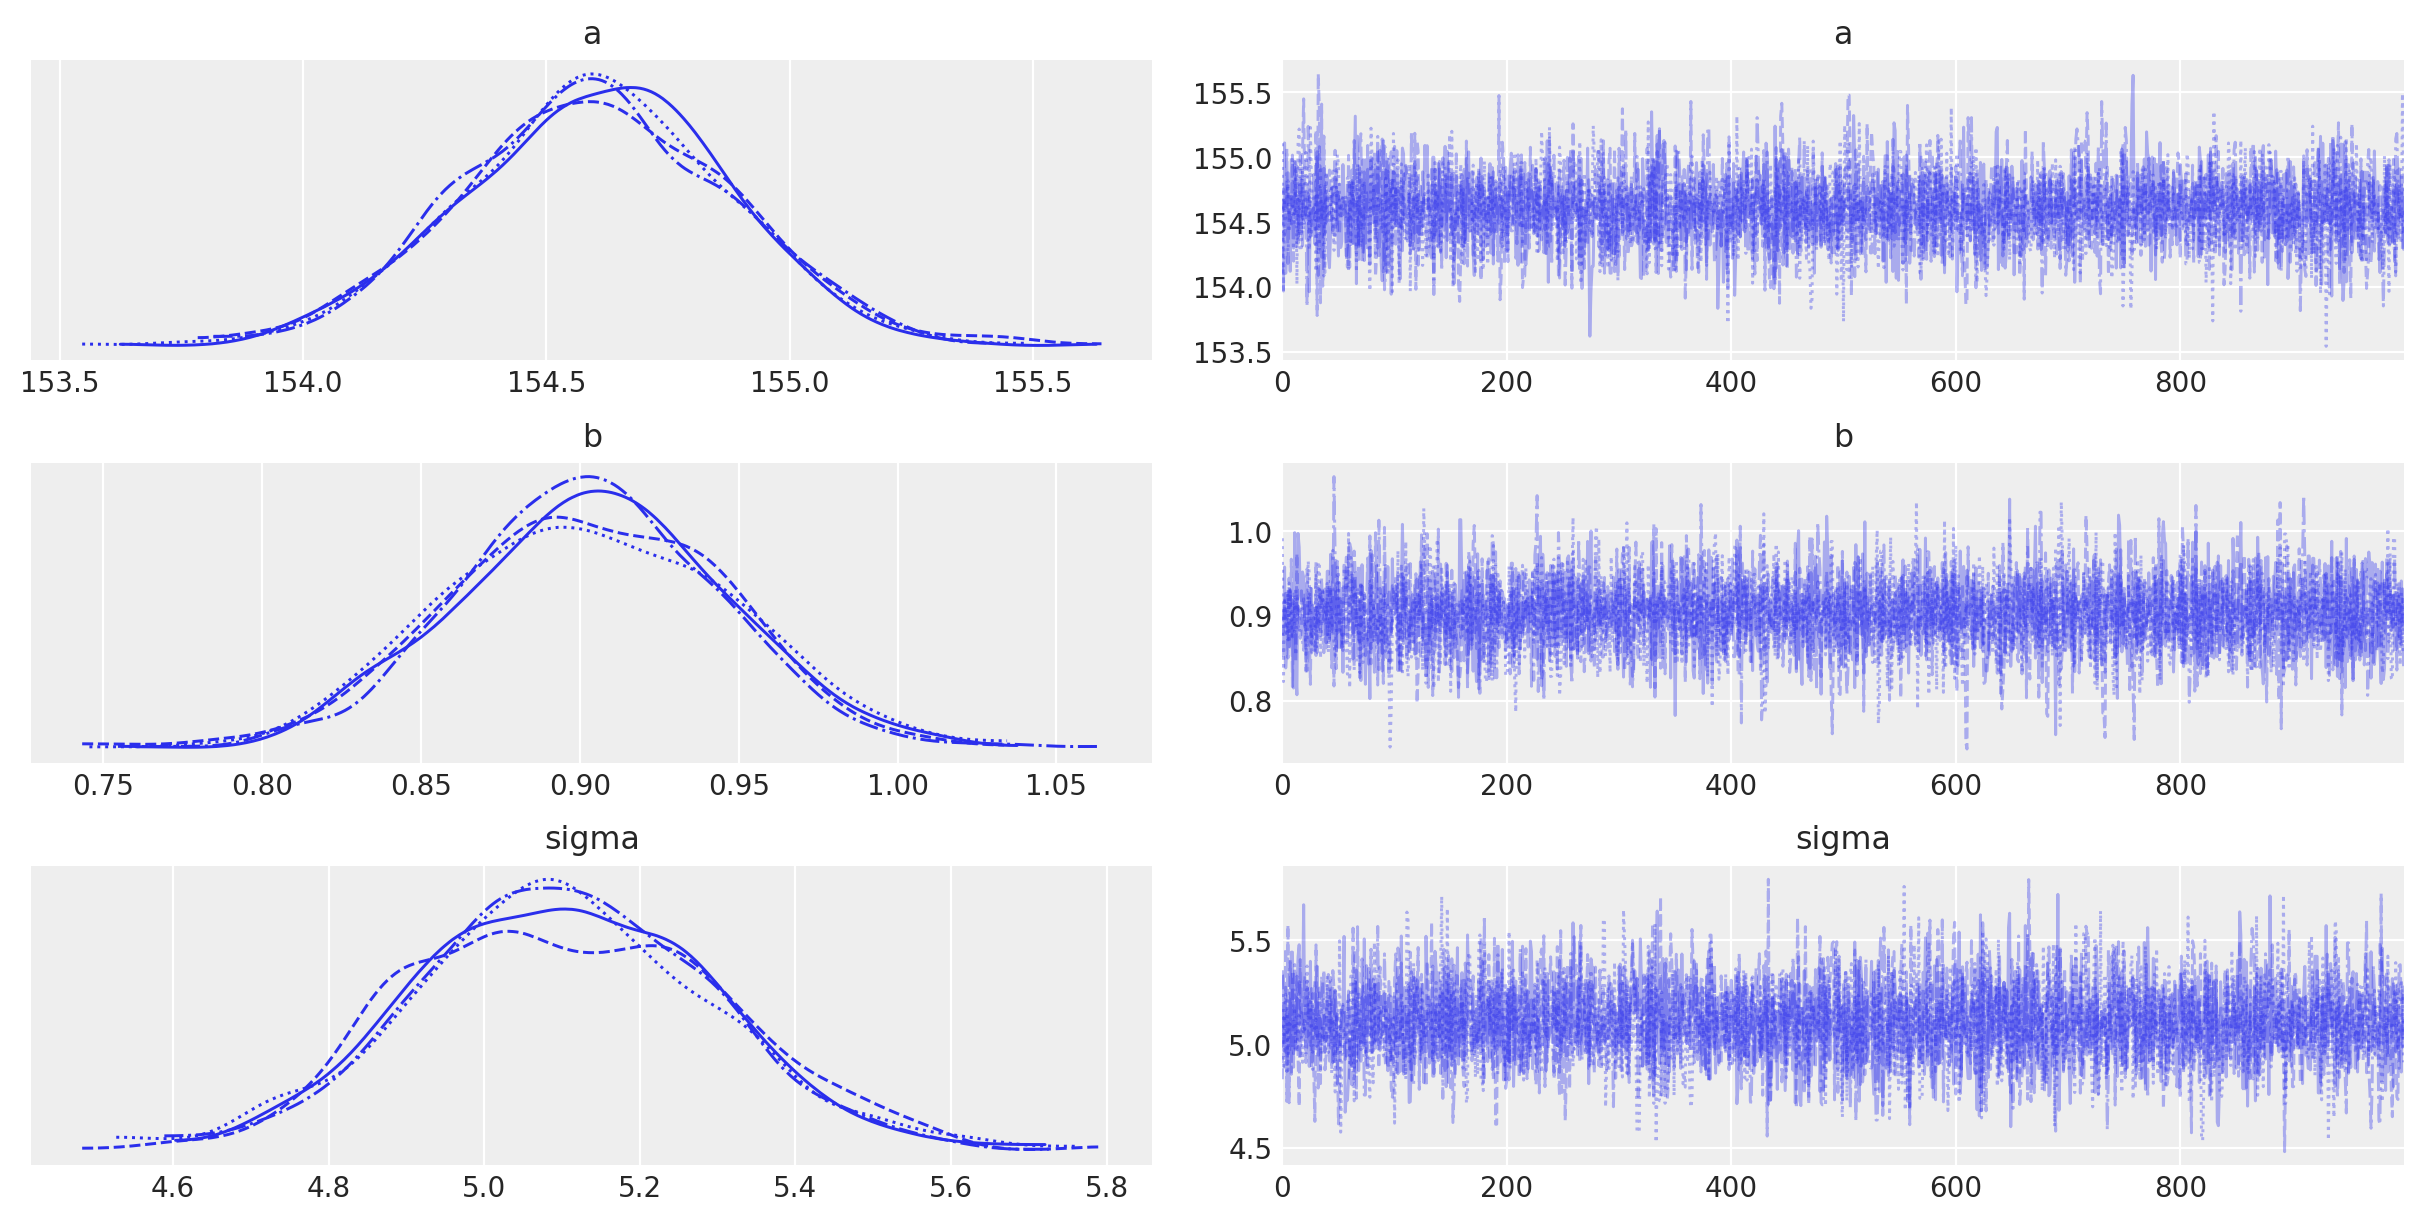

<IPython.core.display.Javascript object>

In [32]:
with heights_model:
    az.plot_trace(trace_m)

Per the PyMC documentation: "The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The beta variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients."

# Plot the posterior inference against the data.

*I believe when it says "plotting the posterior inference" that refers to the parameters, the fitted line.*

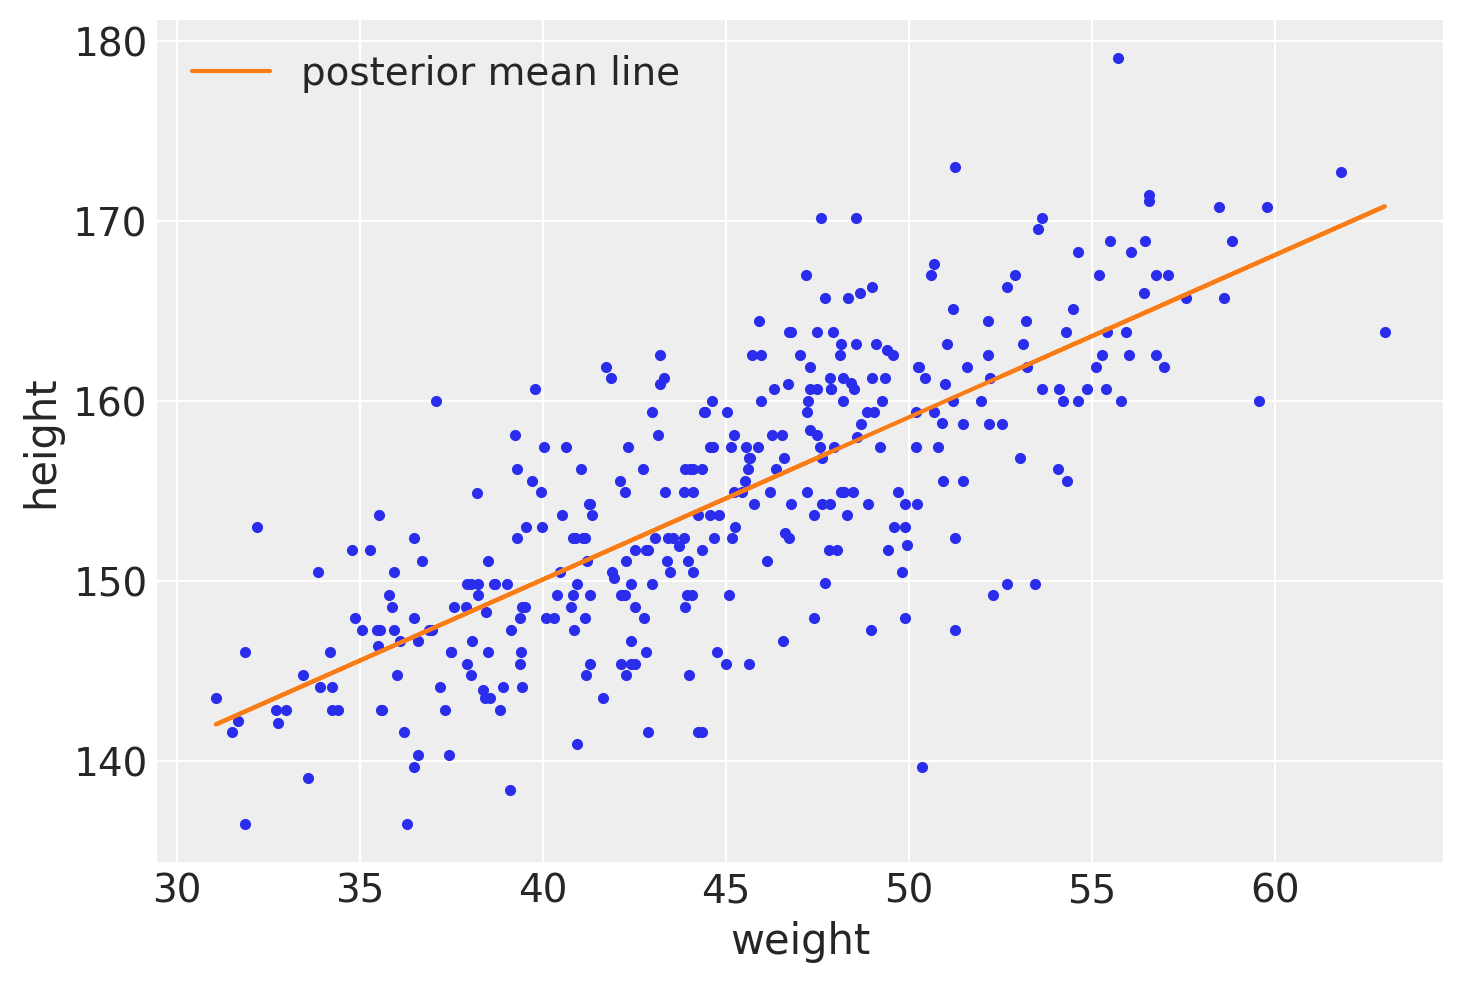

<IPython.core.display.Javascript object>

In [158]:
plt.plot(d2.weight, d2.height, ".")
plt.plot(
    d2.weight,
    trace_m2["a"].mean() + trace_m2["b"].mean() * (d2.weight - xbar),
    label="posterior mean line",
)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0])
plt.legend()

It's important to remember that the line drawn represents the posterior **mean** line. It is the most plausible line, but it's helpful to keep in mind that there's uncertainty and other lines are plausible (albeit with lower probability).

## Add uncertainty around the mean

But remember each parameter isn't really a single number. Each parameter has its own distribution and so we can take uncertainty into account. From the book: "So how can we get that uncertainty onto the plot? Together, a combination of α and β define a line. And so we could sample a bunch of lines from the posterior distribution. Then we could display those lines on the plot, to visualize the uncertainty in the regression relationship."

Here again are the returned parameters from the posterior distribution, but keep in mind that we are **not using sigma** in the next few plots, which only are plausible *mean* lines.

In [159]:
trace_m2_df.head()

,a,b,sigma
0,154.589194,0.889071,4.885394
1,154.589194,0.889071,4.885394
2,154.818923,0.838186,5.271951
3,154.920790,0.987778,5.107954
4,154.920790,0.987778,5.107954


<IPython.core.display.Javascript object>

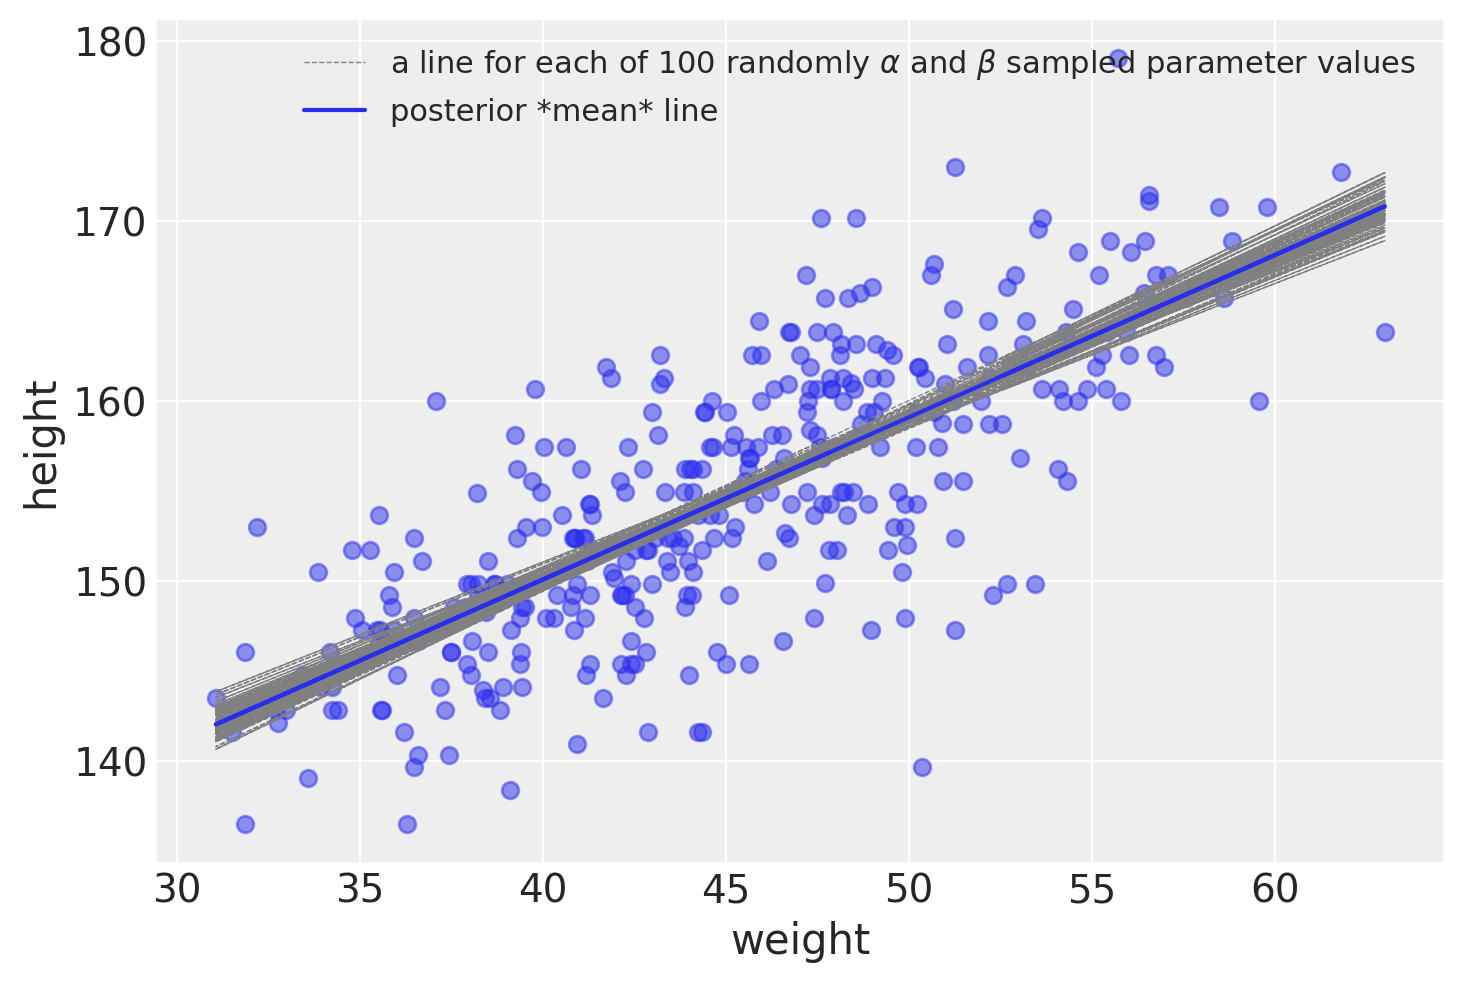

<IPython.core.display.Javascript object>

In [166]:
f, ax1 = plt.subplots()

# Plotting the data as a scatter plot
ax1.scatter(d2["weight"], d2["height"], alpha=0.5)

# Plotting mean lines using the first 100 sampled values for alpha and beta parameters
# note that sigma is not used
for i in range(100):
    ax1.plot(
        d2["weight"],
        trace_m2_df["a"][i] + trace_m2_df["b"][i] * (d2["weight"] - xbar),
        color="gray",
        linewidth=0.5,
        linestyle="dashed",
    )

# Plotting the 100th for labeling purposes
ax1.plot(
    d2["weight"],
    trace_m2_df["a"][i] + trace_m2_df["b"][i] * (d2["weight"] - xbar),
    color="gray",
    linewidth=0.5,
    linestyle="dashed",
    label=r"a line for each of 100 randomly $\alpha$ and $\beta$ sampled parameter values",
)

# Plotting the overall mean line
ax1.plot(
    d2["weight"],
    trace_m2["a"].mean() + trace_m2["b"].mean() * (d2["weight"] - xbar),
    label="posterior *mean* line",
)

ax1.set_xlabel("weight")
ax1.set_ylabel("height")
ax1.legend(fontsize=11)

Even with these 100 lines, you can see how tight the approximations are. (Note that this is showing something different than what's on page 103.) Nevertheless, there's still uncertainty.

# Making predictions with given values

Now that we have a good grasp of the data, we can make *posterior* predictions. Functionally, what we are doing is  taking into account the probability distributions of each parameter (alpha, beta, sigma) when making the prediction.

However, it was not intuitive to me to see how to carry this out mechanically using `pymc`. Let's walk through this step-by-step since there are different ways we can capture uncertainty.

One thing that I had some trouble grasping was the distinction in these two equations:

$\text{height}_i$ ~ Normal($\mu_i, \sigma$)
<br>
$\mu_i = \alpha + \beta(x_i  - \bar{x})$

The first line is *actual* height, that incorporates the uncertainty of all parameters. The second line is *average* height. Note that $\sigma$ is not represented but $\alpha$ and $\beta$ are both vectors so $\mu_i$ will also be a vector for a single weight value (or a matrix when looking at all weight values, see below). It's taken me time to grasp the difference but we'll work with this now.

# Predictions for average or expected height

The first step is looking at the uncertainty for $\mu_i$ or average height *ignoring* $\sigma$ for now. It is represented in this formula:
<br>
$\mu_i = \alpha + \beta(x_i - \bar{x}$)

We'll look first at a single weight value before looking at all weight values

# Look only at single weight value
The first is focusing on a single weight value. Let's take the first weight, 45. We can use the formula for our line and simply plug in the value of 45 for $x_i$. We will get back a vector of predicted means since $\alpha$ and $\beta$ are vectors.

In [41]:
mu_at_45 = df_sampled_params["a"] + df_sampled_params["b"] * (45 - xbar)
mu_at_45

0       154.038708
1       153.978171
2       155.120183
3       154.114503
4       154.336424
           ...    
3995    154.535375
3996    154.517126
3997    154.868261
3998    154.294376
3999    154.882975
Length: 4000, dtype: float64

<IPython.core.display.Javascript object>

In [42]:
type(mu_at_45)

pandas.core.series.Series

<IPython.core.display.Javascript object>

Text(0.5, 0, 'mu|weight=45')

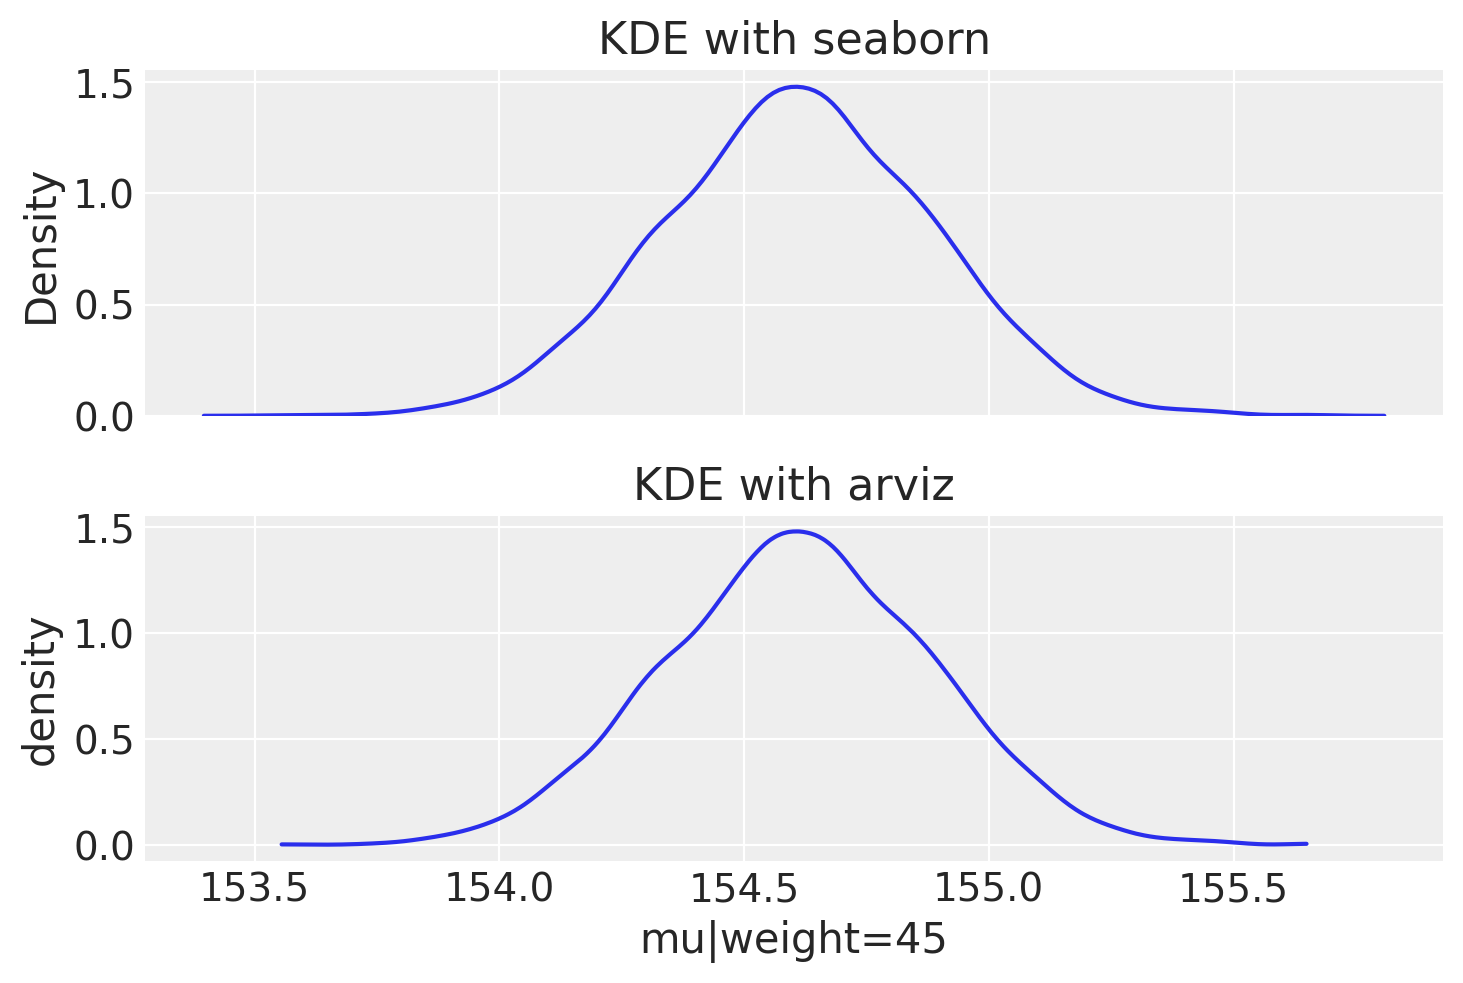

<IPython.core.display.Javascript object>

In [43]:
# Just showing both ways
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
sns.kdeplot(mu_at_45, ax=ax1)
ax1.set_title("KDE with seaborn")

az.plot_kde(mu_at_45, ax=ax2)
ax2.set_title("KDE with arviz")
ax2.set_ylabel("density")
ax2.set_xlabel("mu|weight=45")

In [44]:
# Get 89% compatibility interval
az.hpd(np.array(mu_at_45))

/Users/blacar/opt/anaconda3/envs/stats_rethinking_min/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(


array([154.18730325, 155.06312313])

<IPython.core.display.Javascript object>

# All weight values drawing 89% intervals around the average slope

This is taken from the repo: "We are doing manually, in the book is done using the `link` function. In the book on code 4.58 the following operations are performed manually."

The line for `mu_pred` can be explained. Unlike the example above where `mu` was a vector when evaluating at had for a single weight value, we will now return a matrix. Note: When we initialize the matrix, we multiply by nchains to represent all the valid MCMC samples. This [Stack Overflow link](https://stackoverflow.com/questions/49825216/what-is-a-chain-in-pymc3) was included above but it explains how MCMC uses multiple chains.

In [45]:
weight_seq = np.arange(25, 71)

# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
trace_m_thinned = trace_m[::10]

# See note above about the next line
mu_pred = np.zeros((len(weight_seq), len(trace_m_thinned) * trace_m.nchains))

# Fill out the matrix in this loop
for i, w in enumerate(weight_seq):
    mu_pred[i] = trace_m_thinned["a"] + trace_m_thinned["b"] * (w - d2.weight.mean())

<IPython.core.display.Javascript object>

In [46]:
mu_pred.shape

(46, 400)

<IPython.core.display.Javascript object>

In [47]:
mu_pred[0:5, :]

array([[136.96295529, 138.00848209, 136.92683322, ..., 136.22104344,
        136.67945888, 136.79275424],
       [137.81674294, 138.8235094 , 137.81442571, ..., 137.11968341,
        137.55801384, 137.68015387],
       [138.67053059, 139.63853671, 138.7020182 , ..., 138.01832338,
        138.4365688 , 138.5675535 ],
       [139.52431824, 140.45356402, 139.5896107 , ..., 138.91696335,
        139.31512375, 139.45495312],
       [140.37810589, 141.26859133, 140.47720319, ..., 139.81560332,
        140.19367871, 140.34235275]])

<IPython.core.display.Javascript object>

# Side code for inspection

Instead of a vector as we had for a single weight value, we now have a matrix.

In [48]:
# Inspecting the trace_m[::10]
len(trace_m[::10]["a"])

400

<IPython.core.display.Javascript object>

In [49]:
# https://stackoverflow.com/questions/49825216/what-is-a-chain-in-pymc3
trace_m.nchains

4

<IPython.core.display.Javascript object>

In [50]:
# A way to take every nth value
["a", "b", "c", "d", "e", "f"][::2]

['a', 'c', 'e']

<IPython.core.display.Javascript object>

# Plot uncertainty for $\mu$

Text(0.5, 1.0, 'Uncertainty of $\\mu_i$, the linear model of the mean')

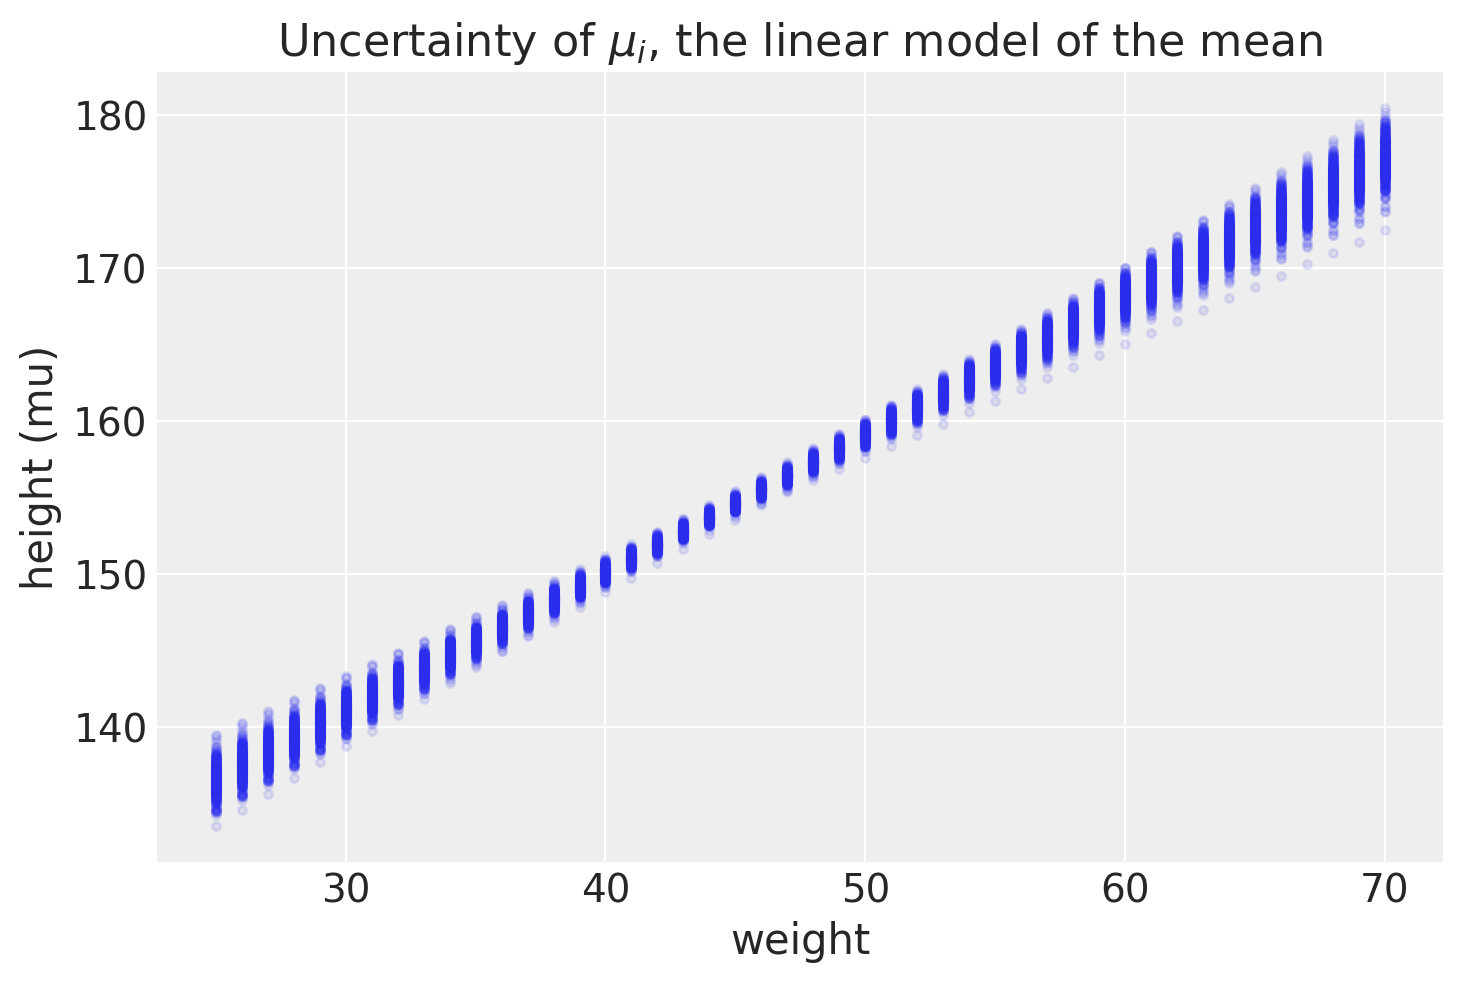

<IPython.core.display.Javascript object>

In [51]:
plt.plot(weight_seq, mu_pred, "C0.", alpha=0.1)
plt.xlabel("weight")
plt.ylabel("height (mu)")
plt.title(r"Uncertainty of $\mu_i$, the linear model of the mean")

Show numerical values for $\mu_i$ at each weight.

In [52]:
mu_mean = mu_pred.mean(1)
# mu_hpd = az.hpd(mu_pred.T)
mu_hpd = az.hdi(mu_pred.T)  # az.hdi is replacing az.hpd (gives same answer)

pred_table = pd.DataFrame(
    {
        "weight": weight_seq,
        "mu_mean": mu_mean,
        "5perc": mu_hpd[:, 0],
        "94perc": mu_hpd[:, 1],
        "89perc_range": mu_hpd[:, 1] - mu_hpd[:, 0],
    }
)
pred_table

/Users/blacar/opt/anaconda3/envs/stats_rethinking_min/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


,weight,mu_mean,5perc,94perc,89perc_range
0,25,136.584283,135.244409,138.149936,2.905527
1,26,137.485512,136.216741,138.982427,2.765686
2,27,138.386741,137.189073,139.803331,2.614258
3,28,139.287970,138.161405,140.635757,2.474352
4,29,140.189199,139.126079,141.481853,2.355774
5,30,141.090428,140.076360,142.283424,2.207063
6,31,141.991657,141.049043,143.118885,2.069842
7,32,142.892886,142.012081,143.971891,1.959810
8,33,143.794115,142.939737,144.764213,1.824477
9,34,144.695344,143.922837,145.612061,1.689224


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking_min/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


(31.071052, 62.992589)

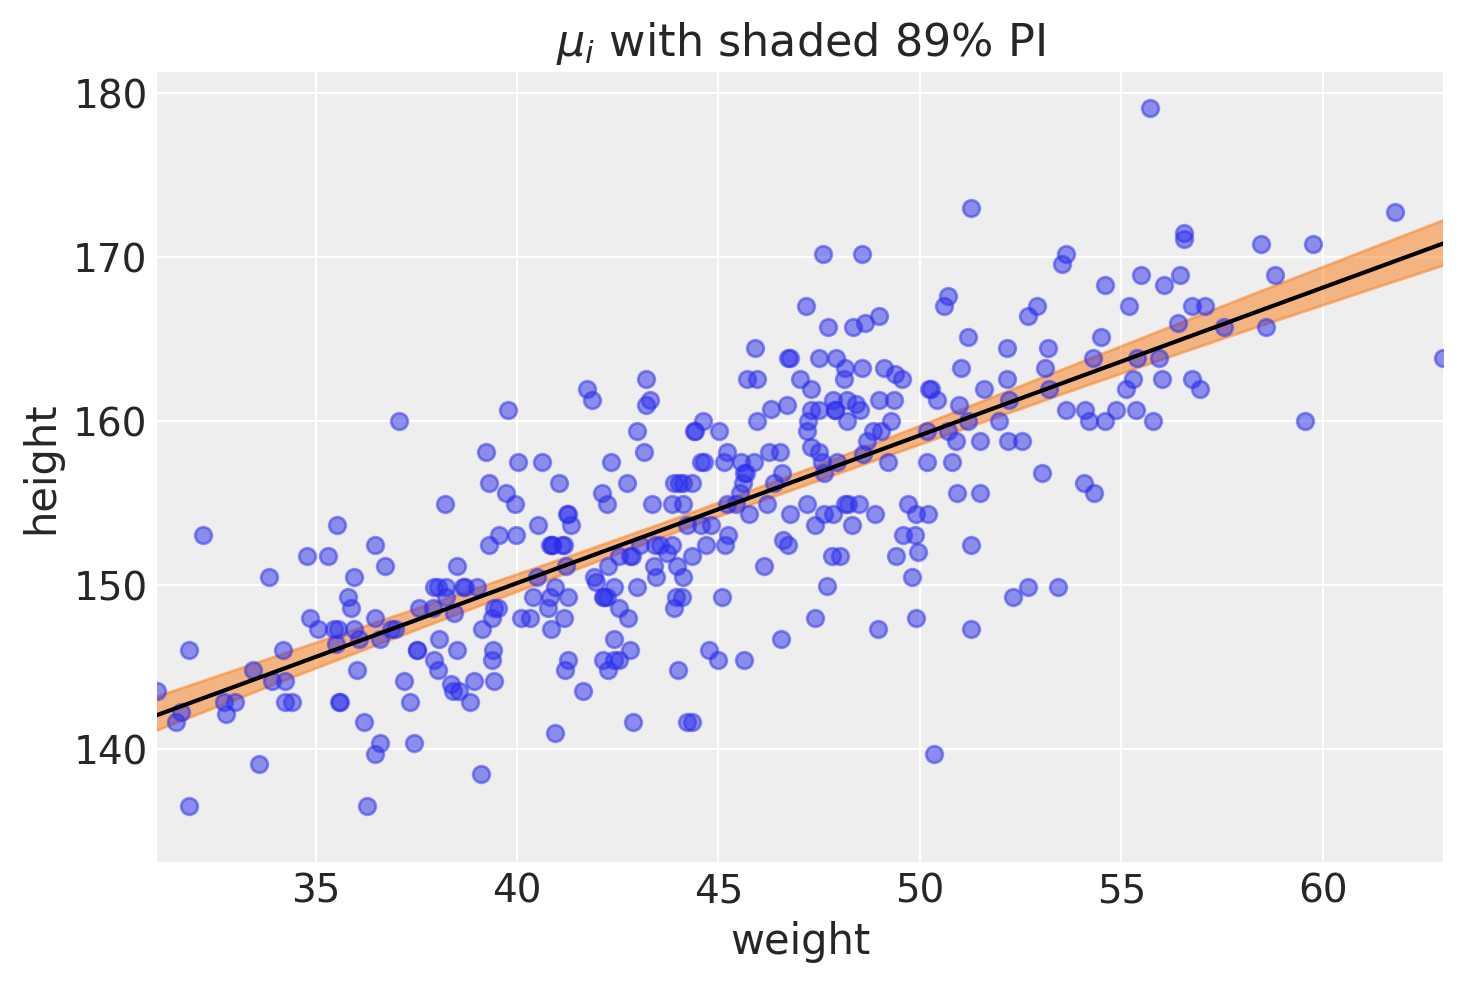

<IPython.core.display.Javascript object>

In [53]:
az.plot_hdi(weight_seq, mu_pred.T)  # Plots the shaded region for 89% PI
plt.scatter(
    d2.weight, d2.height, alpha=0.5
)  # Scatter plot with alpha set to see overlap
plt.plot(weight_seq, mu_mean, "k")  # MAP line (aka mean mu for each weight)
plt.xlabel("weight")
plt.ylabel("height")
plt.title(r"$\mu_i$ with shaded 89% PI")
plt.xlim(d2.weight.min(), d2.weight.max())

**A summary of "the recipe" for generating predictions and intervals for $\mu_i$**

(1) Generate distributions of posterior values for μ. The default behavior of `link` (his package) is to use the original data, so you have to pass it a list of new horizontal axis values you want to plot posterior predictions across.

(2) Use summary functions like mean or PI to find averages and lower and upper bounds of μ for each value of the predictor variable.

(3) Finally, use plotting functions like lines and shade to draw the lines and intervals. Or you might plot the distributions of the predictions, or do further numerical calculations with them. It’s really up to you.

"This recipe works for every model we fit in the book. As long as you know the structure of the model—how parameters relate to the data—you can use samples from the posterior to describe any aspect of the model’s behavior."

# Predictions for actual height

We return now to the original problem where we are seeking predictions for actual height. We will produce compatability intervals where we'd expect to see *any* observed height (note how the uncertainty region for $\mu_i$ as shown above is much narrower than where the points are.)

We will do something similar as what we did above but this time incorporating $\sigma$.

$\text{height}_i$ ~ Normal($\mu_i, \sigma$)

The strategy to do this will depend on simulations. PyMC has a function `sample_posterior_predictive` that can use the trace object and model that we defined above.

Documentation is [here](https://docs.pymc.io/notebooks/posterior_predictive.html) and discussions are [here](https://discourse.pymc.io/t/how-to-predict-new-values-on-hold-out-data/2568/3) and [here, although mostly old](https://stackoverflow.com/questions/33249122/generating-predictions-from-inferred-parameters-in-pymc3).

This is in the PyMC Jupyter notebook for this code: "Now we are going to use sample_posterior_predictive() from PyCM3. This function gives us posterior predictive samples, that is for each value of the input variable we get a sample (from the posterior) of the output variable. Thus in the following example the shape of `height_pred['height'].shape` is (200, 352)." The original weights are inherently part of the model.

In [54]:
# Predict heights

# set parameter to 200 to match the notebook example
# could set to 400 to match the samples and nchains
height_pred = pm.sample_posterior_predictive(trace_m_thinned, 200, heights_model)
height_pred

/Users/blacar/opt/anaconda3/envs/stats_rethinking_min/lib/python3.8/site-packages/pymc3/sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


{'height': array([[157.76607099, 144.39905908, 135.52917989, ..., 150.62400376,
         171.01106671, 160.26328561],
        [155.59488012, 153.621877  , 144.58341333, ..., 161.15282059,
         163.54618201, 165.55950902],
        [156.42475631, 147.32425603, 142.3551614 , ..., 165.49679542,
         167.71096337, 164.83148372],
        ...,
        [154.83701283, 148.06365719, 148.17304493, ..., 155.47974517,
         176.93353614, 160.95832689],
        [154.35127163, 149.97539033, 138.52269332, ..., 163.1358433 ,
         165.2502627 , 162.21839553],
        [162.84263397, 140.53247864, 136.86673483, ..., 171.21904852,
         158.72606667, 161.27956305]])}

<IPython.core.display.Javascript object>

In [55]:
height_pred["height"].shape

(200, 352)

<IPython.core.display.Javascript object>

The 352 comes from the dimensions of the dataframe `d2`.

In [56]:
d2.shape

(352, 4)

<IPython.core.display.Javascript object>

In [57]:
# height_pred_hpd = az.hpd(height_pred["height"])
height_pred_hpd = az.hdi(height_pred["height"])  # hdi replacing hpd function
height_pred_hpd

/Users/blacar/opt/anaconda3/envs/stats_rethinking_min/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


array([[149.08290066, 164.7539239 ],
       [139.37059735, 155.29392136],
       [135.11515402, 151.44596292],
       [153.41507108, 169.48200727],
       [143.63410494, 158.71824611],
       [164.10192674, 180.97305251],
       [140.72200023, 156.9549368 ],
       [154.18702624, 171.3668329 ],
       [137.21895544, 153.94633405],
       [156.68415797, 171.74517768],
       [150.5268604 , 165.91904956],
       [143.30915319, 158.70010853],
       [138.77901535, 154.14734134],
       [148.34906347, 164.77129916],
       [137.79438668, 154.41374274],
       [151.07914268, 167.42127398],
       [144.85823043, 160.60171429],
       [138.71443033, 155.75450992],
       [150.61061107, 165.5868267 ],
       [144.84446961, 160.83926543],
       [139.55546468, 154.55081177],
       [139.01642411, 154.64098304],
       [138.01702681, 153.75369324],
       [142.83389512, 157.52869902],
       [156.42341996, 172.69096879],
       [139.4948974 , 156.18050248],
       [141.2146444 , 157.78083766],
 

<IPython.core.display.Javascript object>

Note that in our `pred_table` ( ($\mu_i$ means and intervals), we inputted the weights, but here we are using the original input values.

In [124]:
d2.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking_min/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


(31.071052, 62.992589)

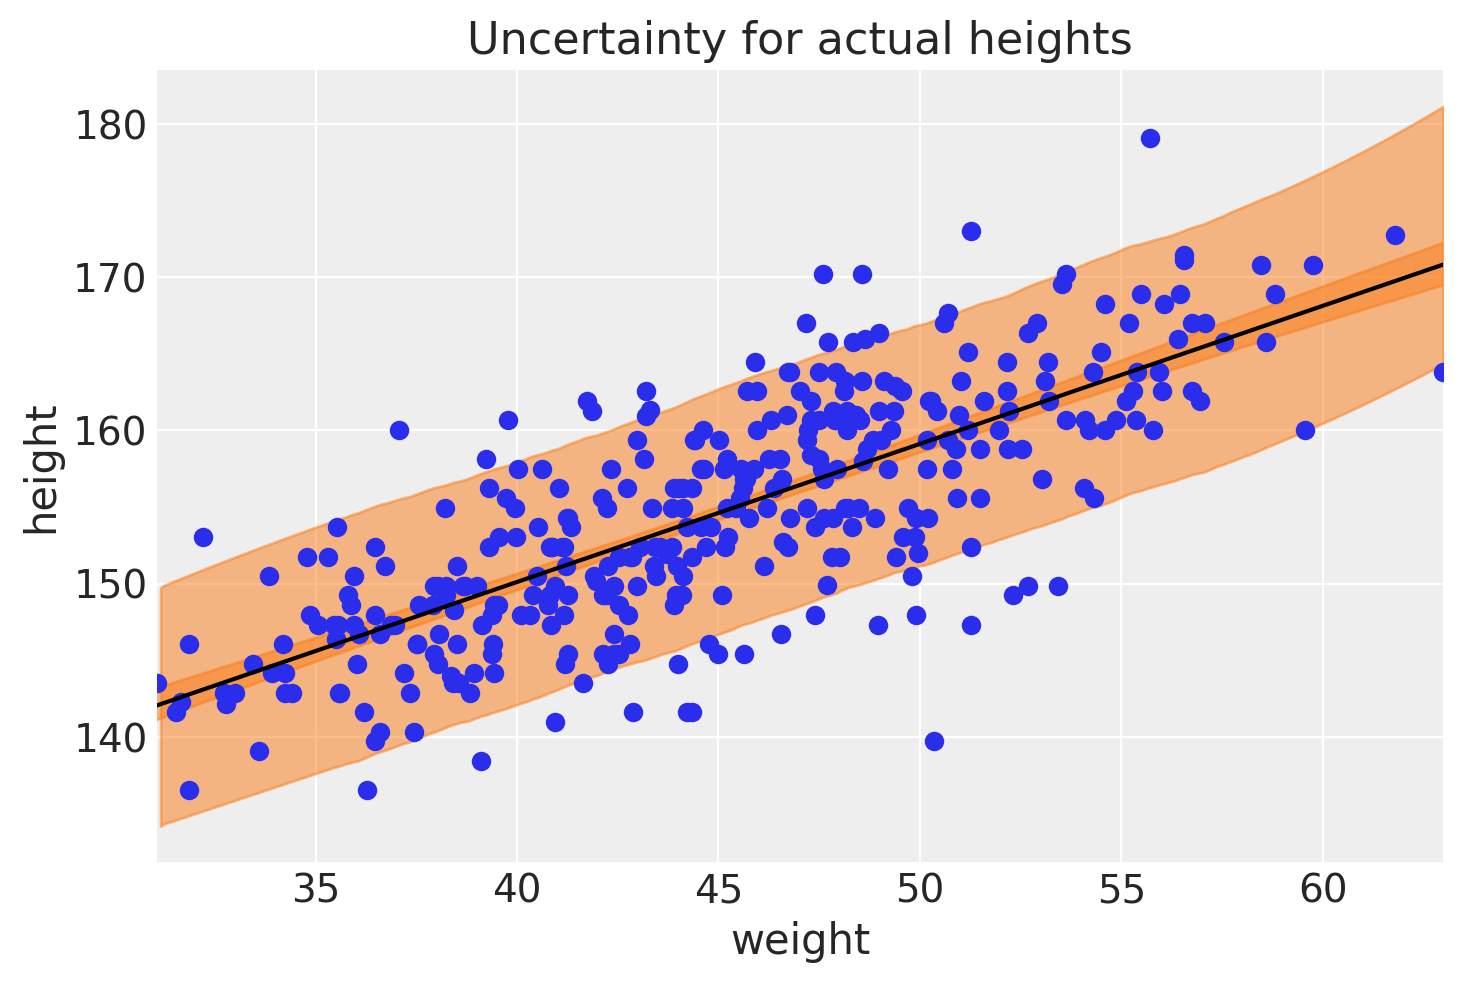

<IPython.core.display.Javascript object>

In [58]:
ax = az.plot_hdi(weight_seq, mu_pred.T)
az.plot_hdi(d2.weight, height_pred["height"], ax=ax)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.title(r"Uncertainty for actual heights")
plt.xlim(d2.weight.min(), d2.weight.max())

# How do we input new values?

The problem however is that so far, we have not inputted new input values. I had to look really closely at the example notebook from the `pymc` repo. This was the most proximal code.

```
# define the data
individuals = np.linspace(1, 4, 4)
weight = np.array([45, 40, 65, 31])
# compute the mean predictions
map_estimates = map_estimates["alpha"] + map_estimates["beta"] * weight
# compute the prediction intervals
pred_intervals = np.array(
    [az.hdi(np.random.normal(loc=compute_mu(x), scale=post_samples[:, 2])) for x in weight]
)
data_dict = {
    "Individual": individuals,
    "Weight": weight,
    "Expected height": means,
    "Low_interval": pred_intervals[:, 0],
    "Upper_interval": pred_intervals[:, 1],
}
```

But some lines were not fully defined, especially the `pred_intervals`. I basically looked at the code and kept backtracking to trace where things came from.

Let's start with one of the easier things. Getting the means at each point was easy because we can simply use the linear model. I'm going to call mine `map_estimates` whereas in the repo code, it ws called `means`.

In [59]:
map_estimates = pm.find_MAP(model=heights_model)
map_estimates

{'a': array(154.60136748),
 'b_log__': array(-0.10172172),
 'sigma_interval__': array(-2.18135226),
 'b': array(0.90328088),
 'sigma': array(5.07188029)}

<IPython.core.display.Javascript object>

# Breaking down repo code for `pred_intervals`

Getting variance is hard and I basically looked at the code and kept backtracking to trace where things came from. Here again is the line:

```
pred_intervals = np.array(
    [az.hdi(np.random.normal(loc=compute_mu(x), scale=post_samples[:, 2])) for x in weight]
)
```

Let's start with `compute_mu`.

```
# define a function to compute mu for all posterior samples at given value of x
def compute_mu(x):
    return post_samples[:, 0] + post_samples[:, 1] * (x)
```

As you can see, the code looks straightforward, but we are still relying on an object that we haven't defined yet: `post_samples`.

We can see where it's defined:

```
# resample for posterior for 10,000 sample
post_samples = np.random.multivariate_normal(map_estimates, var_cov, size=10000)
```

Ok, now we're getting somewhere. I haven't used the numpy method `random.multivariate_normal`, so let's look it up [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html). The description is straightforward:
*"Draw random samples from a multivariate normal distribution. The multivariate normal, multinormal or Gaussian distribution is a generalization of the one-dimensional normal distribution to higher dimensions. Such a distribution is specified by its mean and covariance matrix. These parameters are analogous to the mean (average or “center”) and variance (standard deviation, or “width,” squared) of the one-dimensional normal distribution."*

Let's play around with numpy's 1D function `random.normal` [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html). I have not used this functon a lot but even if I have, it is only to generate samples around one mean and standard deviation.

In [60]:
np.random.normal(loc=0, scale=1, size=10)

array([-0.15805343, -0.21932782, -1.42660607, -0.17753092,  1.02140603,
       -0.12387747, -0.16570988,  1.06341184, -1.4558471 ,  0.17081005])

<IPython.core.display.Javascript object>

It occurred to me that in a [post](https://benslack19.github.io/prior-likelihood-posterior-predictive/), I had used the `scipy.stats` version to get random variates from a binomial distribution. It does not really matter whether I use the `numpy` or the `scipy.stats` version, but it helps to know that there are options and that these  functions are doing similar things.

In [61]:
stats.norm.rvs(loc=0, scale=1, size=10)

array([-0.84219686, -1.09520768, -1.03983743, -0.61457743,  0.00777733,
       -0.19939482, -0.44185688, -0.05856637,  1.68084284,  0.78349649])

<IPython.core.display.Javascript object>

The key realization from inspecting the `pymc` code is that this function can be leveraged to have different mean and standard deviation for each draw. That is, `loc` and `scale` can be vectors. I'll vary the vectors for each so that you can appreciate the resulting vector.

In [62]:
stats.norm.rvs(
    loc=[1, 1, 1, 10, 10, 10, 20, 20, 20], scale=[0.5, 1, 2, 0.5, 1, 2, 0.5, 1, 2]
)

array([ 1.99035372,  1.82764418,  0.81795148,  9.68734371,  9.77800381,
       13.00311022, 20.34151817, 20.71513467, 15.73352397])

<IPython.core.display.Javascript object>

Now let's look at the [multivariate version](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html) of this function. The main difference is that the `scale` parameter which represents the standard deviation in the 1D function, is replaced with the `cov` parameter which represents the covariance matrix. Otherwise, the syntax is similar.

`stats.multivariate_normal.rvs(mean=None, cov=1)    # We'll substitute later`   

In the homework question, we got the covariance matrix way at the beginning from the `pymc` `trace` object (after being converted to a dataframe). Here it is again.

In [63]:
trace_m_df.cov().round(3)

,a,b,sigma
a,0.075,0.000,0.000
b,0.000,0.002,-0.000
sigma,0.000,-0.000,0.038


<IPython.core.display.Javascript object>

Remember that the `trace_dm_df` object is just an array of all the samples and their parameters.

In [64]:
trace_m_df

,a,b,sigma
0,154.030585,0.853788,4.989442
1,153.969973,0.861619,5.128790
2,155.111070,0.957769,5.067568
3,154.106523,0.838728,4.961068
4,154.328210,0.863311,5.160797
...,...,...,...
3995,154.527044,0.875573,4.883293
3996,154.508437,0.913224,5.001473
3997,154.860021,0.866046,5.089966
3998,154.285508,0.932101,5.019234


<IPython.core.display.Javascript object>

Great - now what do we put for the `loc` parameter? We can simply use the linear equation that we used when evaluating the uncertainty for $\mu_i$. (Up above, I manually created a dataframe called `df_sampled_params` before I realized that `trace_m_df` was exactly the same thing. I'll use the latter in this code since that's what I'll likely use moving forward.

Let's look at the first weight value. A reminder that since $\alpha$ and $\beta$ are vectors, the output is also a vector.

In [65]:
trace_m_df["a"] + trace_m_df["b"] * (45 - xbar)

0       154.038708
1       153.978171
2       155.120183
3       154.114503
4       154.336424
           ...    
3995    154.535375
3996    154.517126
3997    154.868261
3998    154.294376
3999    154.882975
Length: 4000, dtype: float64

<IPython.core.display.Javascript object>

The `pymc` repo places this in a function, but I will leave it this way since it is clearer to me where things come from.

We now have all of our pieces to input the appropriate parameters to `stats.multivariate_normal.rvs`.

# Getting the answer

In [66]:
trace_m_thinned_df = pm.trace_to_dataframe(trace_m_thinned)
trace_m_thinned_df

,a,b,sigma
0,154.030585,0.853788,4.989442
1,154.301274,0.815027,4.953903
2,154.670238,0.887592,5.068407
3,154.779148,0.909967,4.991721
4,154.695843,0.938519,5.229024
...,...,...,...
395,154.639729,0.873898,5.488241
396,154.843262,0.848050,5.197252
397,154.185293,0.898640,4.594779
398,154.242199,0.878555,4.815304


<IPython.core.display.Javascript object>

In [67]:
trace_m_df.head()

,a,b,sigma
0,154.030585,0.853788,4.989442
1,153.969973,0.861619,5.128790
2,155.111070,0.957769,5.067568
3,154.106523,0.838728,4.961068
4,154.328210,0.863311,5.160797


<IPython.core.display.Javascript object>

In [68]:
weights = [45, 40, 65, 31]

for weight in weights:

    draw_mvs = stats.multivariate_normal.rvs(
        mean=trace_m_thinned_df["a"] + trace_m_thinned_df["b"] * (weight - xbar),
        cov=trace_m_thinned_df["sigma"],
    )

    print("weight: ", weight, "mean: ", draw_mvs.mean(), "HPD: ", az.hdi(draw_mvs))

weight:  45 mean:  154.63220571597287 HPD:  [150.90097197 158.07357193]
weight:  40 mean:  150.21225662297564 HPD:  [146.78575231 153.69942243]
weight:  65 mean:  172.5794301580685 HPD:  [168.23376245 176.33321173]
weight:  31 mean:  142.0277398053202 HPD:  [137.87581415 145.49518784]


<IPython.core.display.Javascript object>

I am confused because, while the means match the answer key, my intervals do not. This is from the answer key.

```
weight Eh L89 U89
45 154.7 146.7 162.8
40 150.4 142.3 158.7
65 172.6 163.9 180.9
31 142.0 134.3 150.1
```

# Something unexpected happened
My intervals are narrower than the expected result. I think I realized what happened. I was going directly from sampled parameters to predicting heights when I should have used `stats.multivariate_normal.rvs` to *simulate* parameters further. **Still unclear why this is needed...**

In [69]:
map_estimates

{'a': array(154.60136748),
 'b_log__': array(-0.10172172),
 'sigma_interval__': array(-2.18135226),
 'b': array(0.90328088),
 'sigma': array(5.07188029)}

<IPython.core.display.Javascript object>

In [70]:
[map_estimates[var] for var in ["a", "b", "sigma"]]

[array(154.60136748), array(0.90328088), array(5.07188029)]

<IPython.core.display.Javascript object>

In [71]:
# resample for posterior for 10,000 sample

post_samples = np.random.multivariate_normal(
    mean=[map_estimates[var] for var in ["a", "b", "sigma"]],
    cov=trace_m_df.cov(),
    size=10 ** 4,
)

post_samples = pd.DataFrame(post_samples, columns=["alpha", "beta", "sigma"])
post_samples

,alpha,beta,sigma
0,154.671015,0.963531,4.884989
1,154.309989,0.920168,4.595077
2,154.464974,0.933159,5.012370
3,154.468669,0.867361,4.979891
4,154.415719,0.874582,5.089663
...,...,...,...
9995,154.496114,0.874834,5.280387
9996,154.673126,0.846705,4.895267
9997,154.334837,0.915975,5.303742
9998,154.461984,0.950782,5.195964


<IPython.core.display.Javascript object>

In [72]:
weights = [45, 40, 65, 31]

for weight in weights:
    draw = stats.norm.rvs(
        loc=post_samples["alpha"] + post_samples["beta"] * (weight - xbar),
        scale=post_samples["sigma"],
    )

    print("weight: ", weight, "mean: ", draw.mean(), "HPD: ", az.hdi(draw))

weight:  45 mean:  154.61464295159112 HPD:  [146.9149581  163.04534031]
weight:  40 mean:  150.10286867025042 HPD:  [142.06975666 158.59890143]
weight:  65 mean:  172.62148451094748 HPD:  [164.42670793 180.68832954]
weight:  31 mean:  142.01930337929124 HPD:  [133.87594119 150.15159424]


<IPython.core.display.Javascript object>

# A lesson about uncertainty in parameter values and uncertainty in the sampling process

I get the "right" answer now, but I have to keep this straight in my head. This was in the book.

**Rethinking: Two kinds of uncertainty.** In the procedure above, we encountered both uncertainty in parameter values and uncertainty in a sampling process. These are distinct concepts, even though they are processed much the same way and end up blended together in the posterior predictive simulation. The posterior distribution is a ranking of the relative plausibilities of every possible combination of parameter values. The distribution of simulated outcomes, like height, is instead a distribution that includes sampling variation from some process that generates Gaussian random variables. This sampling variation is still a model assumption. It’s no more or less objective than the posterior distribution. Both kinds of uncertainty matter, at least sometimes. But it’s important to keep them straight, because they depend upon different model assumptions. Furthermore, it’s possible to view the Gaussian likelihood as a purely epistemological assumption (a device for estimating the mean and variance of a variable), rather than an ontological assumption about what future data will look like. In that case, it may not make complete sense to simulate outcomes.

The best thing for me now is to stop and think about it later. Good job.

# Revisiting 2/27/21 - finding a more straightforward solution

This was still confusing to me. It didn't make sense why you'd have to resample parameters again. I went back and used the one-dimensional `stats.norm` function off of the parameters that came with the original `trace` object.

In [73]:
trace_m_df.head()

,a,b,sigma
0,154.030585,0.853788,4.989442
1,153.969973,0.861619,5.128790
2,155.111070,0.957769,5.067568
3,154.106523,0.838728,4.961068
4,154.328210,0.863311,5.160797


<IPython.core.display.Javascript object>

In [74]:
# Using 1D stats.norm function

weights = [45, 40, 65, 31]

for weight in weights:

    draw_1d = stats.norm.rvs(
        loc=trace_m_df["a"] + trace_m_df["b"] * (weight - xbar),
        scale=trace_m_df["sigma"],
    )

    print("weight: ", weight, "mean: ", draw_1d.mean(), "HPD: ", az.hdi(draw_1d))

weight:  45 mean:  154.63234980040386 HPD:  [146.62192853 163.26495852]
weight:  40 mean:  150.17554635139527 HPD:  [142.12114212 158.5340181 ]
weight:  65 mean:  172.66663394691923 HPD:  [164.43878983 180.4417578 ]
weight:  31 mean:  141.87069252325466 HPD:  [133.95382699 150.00822713]


<IPython.core.display.Javascript object>

I think this could be a more straightforward solution then what is on the repo.

In [75]:
# To match the repo syntax, you can use numpy.random.normal

weights = [45, 40, 65, 31]

for weight in weights:

    draw_1d = np.random.normal(
        loc=trace_m_df["a"] + trace_m_df["b"] * (weight - xbar),
        scale=trace_m_df["sigma"],
    )

    print("weight: ", weight, "mean: ", draw_1d.mean(), "HPD: ", az.hdi(draw_1d))

weight:  45 mean:  154.54051748958622 HPD:  [146.17849128 162.64999427]
weight:  40 mean:  150.1273260913369 HPD:  [141.65601529 158.42527473]
weight:  65 mean:  172.62346511607223 HPD:  [164.77543839 180.91980713]
weight:  31 mean:  141.96706483889182 HPD:  [134.29884057 150.686806  ]


<IPython.core.display.Javascript object>

In [76]:
draw_1d.shape

(4000,)

<IPython.core.display.Javascript object>

I'd like to verify that R code is doing the same thing. It looks like it is.

The `quap` function does not look like it produces output of all the samples like the `trace` object here. But you can get samples using `extract.samples` with 10,000 samples being the default. If you look at R code 4.63, then it is doing something similar as what I did above.

# Conclusion

# Appendix: Environment and system parameters

In [4]:
%watermark -n -u -v -iv -w

Last updated: Sat Mar 06 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
seaborn   : 0.11.1
scipy     : 1.6.0
matplotlib: 3.3.4
json      : 2.0.9
pymc3     : 3.11.0
arviz     : 0.11.1
numpy     : 1.20.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>